# `OOD Detection applied to SST2 and IMDB`


In [1]:

import pandas as pd 
import numpy as np 

from tqdm import tqdm
import datasets
from datasets import load_dataset

import pandas as pd 
import numpy as np 

from tqdm import tqdm
from typing import List, Dict


from itertools import chain

import matplotlib.pyplot as plt 
from matplotlib.axes import Axes
import seaborn as sns

import pickle as pkl 
import json

from sklearn.metrics import (
    roc_curve, 
    precision_recall_curve, 
    auc
) 


from transformers import AutoConfig, BertForSequenceClassification

import torch 
from torch import Tensor


from Todd import (
    ScorerType, 
    MahalanobisScorer, 
    CosineProjectionScorer, 
    DataDepthScorer, 
)


from toddbenchmark.classification_datasets import (
    prep_model, 
    load_sst2, 
)
from toddbenchmark.classification_datasets_configs import (
    DATASETS_CONFIGS,
    load_requested_dataset,
)

from toddbenchmark.utils_classification import (
    prepare_detectors,
    evaluate_dataloader,
)


from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

#
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, minmax_scale, MinMaxScaler

#metrics 
from sklearn.metrics import accuracy_score ,balanced_accuracy_score, make_scorer, confusion_matrix, f1_score, classification_report, roc_auc_score


from Todd import (
    ScorerType, 
    MahalanobisScorer, 
    CosineProjectionScorer, 
    DataDepthScorer, 
)

# `Our models`

This work is based on Bert architectures. 

In [2]:
Models = {"BERT": "echarlaix/bert-base-uncased-sst2-acc91.1-d37-hybrid", "DistilBERT": "distilbert-base-uncased-finetuned-sst-2-english"} 

model, tokenizer = prep_model(Models["BERT"], config={"label": 2})

In [3]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=320, bias=True)
              (key): Linear(in_features=768, out_features=320, bias=True)
              (value): Linear(in_features=768, out_features=320, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=320, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

`Datasets`

**In-DS : SST2**

In [3]:
config_args_sst2 = { "tokenizer": tokenizer, "train_size": 3000, "validation_size": 000, "test_size": 3000, "ood_label" : 0}

train_loader_sst2, val_loader_sst2, test_loader_sst2 = load_requested_dataset(config_name="sst2", **config_args_sst2)


Found cached dataset glue (/Users/joevincentgaltie/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
sum(batch["labels"].shape[0] for batch in test_loader_sst2)

KeyboardInterrupt: 

**Out-DS : IMDB**

In [5]:
config_args_imdb = { "tokenizer": tokenizer, "train_size": 0, "validation_size": 0, "test_size": 3000, "ood_label" : 1}


_, _, test_loader_imdb = load_requested_dataset(config_name="imdb", **config_args_imdb)

Found cached dataset imdb (/Users/joevincentgaltie/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

 **very OOD dataset**

In [14]:
config_args_imdb = { "tokenizer": tokenizer, "train_size": 0, "validation_size": 0, "test_size": 3000, "ood_label" : 1}


_, _, test_loader_rte = load_requested_dataset(config_name="rte", **config_args_imdb)

Found cached dataset glue (/Users/joevincentgaltie/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
print(next(iter(train_loader_sst2)))

print(next(iter(test_loader_imdb)))

print(next(iter(test_loader_rte)))

{'text': ['hide new secretions from the parental units ', 'contains no wit , only labored gags ', 'that loves its characters and communicates something rather beautiful about human nature ', 'remains utterly satisfied to remain the same throughout ', 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ', "that 's far too tragic to merit such superficial treatment ", 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ', 'of saucy ', "a depressed fifteen-year-old 's suicidal poetry ", "are more deeply thought through than in most ` right-thinking ' films ", 'goes to absurd lengths ', "for those moviegoers who complain that ` they do n't make movies like they used to anymore ", "the part where nothing 's happening , ", 'saw how bad this movie was ', 'lend some dignity to a dumb story ', 'the greatest musicians '], 'labels': tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,

-------
-------

### `Simplistic supervised approach`

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = BertForSequenceClassification.from_pretrained("echarlaix/bert-base-uncased-sst2-acc91.1-d37-hybrid", num_labels=2,output_hidden_states = True)
model.to(device)

mean_embeddings = torch.zeros(1,768)

with torch.no_grad():
    for batch in tqdm(train_loader_sst2):

        inputs = tokenizer(batch['text'], return_tensors="pt", truncation=True, padding=True)['input_ids'].to(device)
        outputs = model(inputs)

        
        hidden_states = outputs.hidden_states

        for i in range(13):
                embedding_batch=[]
                layer_embeddings = hidden_states[i][:, 0, :]
                embedding_batch.append(layer_embeddings)
                
        embedding_batch_mean= torch.mean(torch.stack(embedding_batch,dim=0),dim=0)

        if mean_embeddings.size() ==(1,768) : 
            mean_embeddings = embedding_batch_mean
        else : 
            mean_embeddings = torch.cat((mean_embeddings, embedding_batch_mean), dim=0)


100%|██████████| 188/188 [01:33<00:00,  2.02it/s]


In [7]:
hidden_in = hidden_states

In [8]:
hidden_in

(tensor([[[ 1.5597e-01, -2.6601e-01, -3.1719e-01,  ..., -4.8019e-03,
            1.4476e-02,  1.5220e-01],
          [ 5.4636e-01,  5.7812e-01,  1.5213e-01,  ...,  4.5618e-01,
            4.5436e-01,  3.2401e-01],
          [ 9.5170e-02,  2.9671e-01, -3.9846e-01,  ..., -7.3581e-01,
           -7.8258e-01, -1.5708e+00],
          ...,
          [ 5.6678e-02, -3.4025e-01,  8.7591e-02,  ...,  1.2868e-04,
           -3.9694e-01, -7.2258e-02],
          [ 6.4300e-02, -3.0502e-01,  2.5136e-01,  ...,  6.6114e-02,
           -4.7288e-01, -4.5710e-02],
          [ 3.5985e-02, -4.2692e-01,  7.2300e-02,  ..., -1.7924e-02,
           -4.7128e-01, -7.0074e-02]],
 
         [[ 1.5597e-01, -2.6601e-01, -3.1719e-01,  ..., -4.8019e-03,
            1.4476e-02,  1.5220e-01],
          [ 1.5144e+00, -4.4829e-01,  3.0224e-01,  ...,  2.9192e-01,
            1.2440e+00, -9.3474e-01],
          [ 1.0959e+00,  3.2115e-01, -5.1600e-01,  ...,  7.1904e-01,
            3.0999e-01,  6.4771e-01],
          ...,
    

In [9]:
mean_embeddings_in_ds = mean_embeddings


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = BertForSequenceClassification.from_pretrained("echarlaix/bert-base-uncased-sst2-acc91.1-d37-hybrid", num_labels=2,output_hidden_states = True)
# model.to(device)

mean_embeddings = torch.zeros(1,768)

with torch.no_grad():
    for batch in tqdm(test_loader_imdb):
        inputs = tokenizer(batch['text'], return_tensors="pt", truncation=True, padding=True)['input_ids'].to(device)
        outputs = model(inputs)

        
        hidden_states = outputs.hidden_states

        for i in range(13):
                embedding_batch=[]
                layer_embeddings = hidden_states[i][:, 0, :]
                embedding_batch.append(layer_embeddings)
                
        embedding_batch_mean= torch.mean(torch.stack(embedding_batch,dim=0),dim=0)

        if mean_embeddings.size() ==(1,768) : 
            mean_embeddings = embedding_batch_mean
        else : 
            mean_embeddings = torch.cat((mean_embeddings, embedding_batch_mean), dim=0)

  0%|          | 0/188 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 188/188 [17:32<00:00,  5.60s/it]


In [11]:
mean_embeddings_out_ds = mean_embeddings

In [12]:
hidden_out = hidden_states

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = BertForSequenceClassification.from_pretrained("echarlaix/bert-base-uncased-sst2-acc91.1-d37-hybrid", num_labels=2,output_hidden_states = True)
# model.to(device)

mean_embeddings = torch.zeros(1,768)

with torch.no_grad():
    for batch in tqdm(test_loader_rte):
        inputs = tokenizer(batch['text'], return_tensors="pt", truncation=True, padding=True)['input_ids'].to(device)
        outputs = model(inputs)

        
        hidden_states = outputs.hidden_states

        for i in range(13):
                embedding_batch=[]
                layer_embeddings = hidden_states[i][:, 0, :]
                embedding_batch.append(layer_embeddings)
                
        embedding_batch_mean= torch.mean(torch.stack(embedding_batch,dim=0),dim=0)

        if mean_embeddings.size() ==(1,768) : 
            mean_embeddings = embedding_batch_mean
        else : 
            mean_embeddings = torch.cat((mean_embeddings, embedding_batch_mean), dim=0)

mean_embeddings_very_out_ds = mean_embeddings

  0%|          | 0/188 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 188/188 [03:49<00:00,  1.22s/it]


In [16]:
hidden_very_out = hidden_states

In [22]:
mean_embeddings_out_ds.mean(axis=0).mean(axis=-1)
mean_embeddings_in_ds.mean(axis=0).mean(axis=-1)

tensor(-0.0083)

In [24]:
mean_embeddings_in_ds.size()

torch.Size([3000, 768])

In [17]:
tensor0 = mean_embeddings_in_ds
tensor1 = mean_embeddings_out_ds
data = np.hstack((tensor0, np.zeros((tensor0.shape[0], 1))))
data = np.vstack((data, np.hstack((tensor1, np.ones((tensor1.shape[0], 1))))))


In [19]:
data.shape

(6000, 769)

In [26]:
#data[:,:-1]
data[:,-1]

array([0., 0., 0., ..., 1., 1., 1.])

In [18]:
x_train,x_test,y_train,y_test=train_test_split(data[:,:-1],data[:,-1],test_size=0.2,shuffle=True)

In [18]:
x_train

array([[-0.55904216, -0.43559647, -0.0313114 , ...,  0.49893102,
         0.09465267, -0.39085919],
       [-0.34506315,  0.04499663,  0.09334722, ...,  0.63350242,
         0.13094577, -0.26817828],
       [-0.20789309,  0.10821149, -0.20289591, ...,  0.03219894,
        -0.03383854, -0.05451637],
       ...,
       [-0.20111321,  0.04926404, -0.12717004, ...,  0.14218518,
         0.08264235, -0.27493972],
       [-0.44319183, -0.42821157,  0.08542095, ...,  0.16278829,
         0.13088672, -0.45157534],
       [-0.46162727, -0.37721238, -0.02091554, ...,  0.23836938,
         0.1703843 , -0.45602089]])

In [24]:
len(x_test)

400

In [20]:
import collections
collections.Counter(y_test)

Counter({1.0: 597, 0.0: 603})

In [21]:
pipe = Pipeline([('XGB', XGBClassifier())])
parameters = { 'XGB__max_depth':[1,2,3,4],
               'XGB__n_estimators':[200,300,400,500]     
               #'RF__class_weight':['balanced', 'balanced_subsample'],
               #'RF__min_samples_split':range(2,10),
               #'RF__min_samples_leaf':range(1,5)
              } # defining parameter space
xgb_clf = GridSearchCV(pipe, parameters, cv=4, scoring ='f1')
xgb_clf.fit(x_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=N...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'XGB__max_depth': [1, 2, 3, 4],
                         'XGB__n_estimators': [200, 300, 400, 500]},
             scoring='f1')

In [33]:
y_test

array([1., 0., 0., ..., 1., 0., 1.])

In [23]:
xgb_clf.predict(x_test)

array([1, 0, 1, ..., 0, 1, 1])

In [24]:
print('Returned hyperparameter: {}'.format(xgb_clf.best_params_))
print('Best classification accuracy in train is: {}'.format(xgb_clf.best_score_))
print('Classification accuracy on test is: {}'.format(f1_score(xgb_clf.predict(x_test),y_test)))

Returned hyperparameter: {'XGB__max_depth': 1, 'XGB__n_estimators': 200}
Best classification accuracy in train is: 0.9995836802664446
Classification accuracy on test is: 1.0


In [25]:
print(xgb_clf.best_params_)

print(f1_score(xgb_clf.predict(x_test),y_test))

print(confusion_matrix(xgb_clf.predict(x_test),y_test))

print(classification_report(xgb_clf.predict(x_test),y_test))

{'XGB__max_depth': 1, 'XGB__n_estimators': 200}
1.0
[[603   0]
 [  0 597]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       603
           1       1.00      1.00      1.00       597

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [26]:
x_test[:,135]

array([ 0.23581612, -0.25889003,  0.45506257, ..., -0.27125096,
        0.27422741,  0.23673633])

In [27]:
print(np.argwhere(xgb_clf.best_estimator_[0].feature_importances_>0))
xgb_clf.best_estimator_[0].feature_importances_[np.argwhere(xgb_clf.best_estimator_[0].feature_importances_>0)]


[[ 26]
 [135]
 [225]
 [270]
 [327]
 [372]
 [447]
 [473]
 [481]
 [483]
 [710]]


array([[0.01510642],
       [0.59271187],
       [0.12673469],
       [0.01469333],
       [0.00111662],
       [0.01038871],
       [0.06692992],
       [0.14920813],
       [0.01863094],
       [0.00255041],
       [0.00192892]], dtype=float32)

In [28]:
tensor0 = mean_embeddings_in_ds
tensor1 = mean_embeddings_very_out_ds
data = np.hstack((tensor0, np.zeros((tensor0.shape[0], 1))))
data = np.vstack((data, np.hstack((tensor1, np.ones((tensor1.shape[0], 1))))))

x_train,x_test,y_train,y_test=train_test_split(data[:,:-1],data[:,-1],test_size=0.2,shuffle=True)


pipe = Pipeline([('XGB', XGBClassifier())])
parameters = { 'XGB__max_depth':[1,2,3,4],
               'XGB__n_estimators':[200,300,400,500]     
               #'RF__class_weight':['balanced', 'balanced_subsample'],
               #'RF__min_samples_split':range(2,10),
               #'RF__min_samples_leaf':range(1,5)
              } # defining parameter space
xgb2_clf = GridSearchCV(pipe, parameters, cv=4, scoring ='f1')
xgb2_clf.fit(x_train, y_train)


print('Returned hyperparameter: {}'.format(xgb2_clf.best_params_))
print('Best classification accuracy in train is: {}'.format(xgb2_clf.best_score_))
print('Classification accuracy on test is: {}'.format(f1_score(xgb2_clf.predict(x_test),y_test)))

Returned hyperparameter: {'XGB__max_depth': 1, 'XGB__n_estimators': 400}
Best classification accuracy in train is: 0.9950508414814049
Classification accuracy on test is: 0.9947826086956523


In [29]:
print(xgb2_clf.best_params_)

print(f1_score(xgb2_clf.predict(x_test),y_test))

print(confusion_matrix(xgb2_clf.predict(x_test),y_test))

print(classification_report(xgb2_clf.predict(x_test),y_test))

{'XGB__max_depth': 1, 'XGB__n_estimators': 400}
0.9947826086956523
[[622   1]
 [  5 572]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       623
           1       1.00      0.99      0.99       577

    accuracy                           0.99      1200
   macro avg       1.00      0.99      0.99      1200
weighted avg       1.00      0.99      0.99      1200



In [30]:
print(np.argwhere(xgb2_clf.best_estimator_[0].feature_importances_>0))
xgb2_clf.best_estimator_[0].feature_importances_[np.argwhere(xgb2_clf.best_estimator_[0].feature_importances_>0)]

[[ 20]
 [ 25]
 [ 52]
 [ 59]
 [ 63]
 [ 65]
 [ 78]
 [ 79]
 [ 84]
 [101]
 [102]
 [110]
 [133]
 [135]
 [144]
 [145]
 [170]
 [174]
 [188]
 [191]
 [200]
 [211]
 [220]
 [223]
 [232]
 [243]
 [244]
 [254]
 [259]
 [261]
 [271]
 [273]
 [301]
 [311]
 [318]
 [321]
 [324]
 [326]
 [355]
 [356]
 [368]
 [370]
 [372]
 [396]
 [402]
 [406]
 [418]
 [421]
 [422]
 [423]
 [425]
 [432]
 [435]
 [437]
 [447]
 [453]
 [458]
 [474]
 [478]
 [481]
 [483]
 [484]
 [489]
 [490]
 [492]
 [498]
 [502]
 [519]
 [521]
 [524]
 [538]
 [550]
 [558]
 [563]
 [564]
 [565]
 [571]
 [576]
 [600]
 [604]
 [606]
 [611]
 [613]
 [617]
 [621]
 [626]
 [633]
 [649]
 [654]
 [656]
 [658]
 [665]
 [672]
 [688]
 [694]
 [699]
 [704]
 [706]
 [709]
 [716]
 [721]
 [729]
 [732]
 [736]
 [740]
 [755]
 [758]
 [763]
 [766]]


array([[2.01289295e-04],
       [1.67538601e-05],
       [3.51903960e-04],
       [4.42179822e-04],
       [1.24058244e-03],
       [2.98577407e-03],
       [8.88011942e-04],
       [9.15906765e-03],
       [1.29157546e-04],
       [1.52885902e-03],
       [1.42361154e-03],
       [1.50656560e-04],
       [4.93899825e-05],
       [3.42892081e-01],
       [9.04341054e-04],
       [2.43582367e-03],
       [1.29693099e-05],
       [2.28087119e-05],
       [3.66856584e-05],
       [1.83598735e-04],
       [8.19190056e-04],
       [5.88445146e-05],
       [2.77882995e-04],
       [7.20144817e-05],
       [5.87575603e-04],
       [1.50631413e-05],
       [6.77770295e-04],
       [2.01954070e-04],
       [1.78416158e-05],
       [1.09761213e-05],
       [5.55594670e-05],
       [3.54268886e-05],
       [5.28318269e-05],
       [2.90777971e-04],
       [5.77328587e-03],
       [1.32873410e-03],
       [7.46360165e-05],
       [8.68441421e-05],
       [1.73629251e-05],
       [1.49287545e-04],


In [32]:
hidden_in[:,0,:][135]

TypeError: tuple indices must be integers or slices, not tuple

**Diagnostic** : **why does xgboost seem to work too perfectly hence not to work**

In [44]:
for i in range(5,13) : 
    print(f'la couche {i} pour le in-ds renvoie la colonne 135 suivante: {hidden_in[i][:, 0, :][:,135]}')
    print(f'la couche {i} pour le out-ds renvoie la colonne 135 suivante: {hidden_out[i][:, 0, :][:,135]}')
    print(f'la couche {i} pour le very-out-ds renvoie la colonne 135 suivante: {hidden_very_out[i][:, 0, :][:,135]}')
    print("")

la couche 5 pour le in-ds renvoie la colonne 135 suivante: tensor([0.6358, 0.7345, 0.6954, 0.6379, 0.7029, 0.7500, 0.6740, 0.6540])
la couche 5 pour le out-ds renvoie la colonne 135 suivante: tensor([0.4800, 0.5494, 0.5234, 0.4711, 0.4185, 0.4106, 0.4346, 0.4160])
la couche 5 pour le very-out-ds renvoie la colonne 135 suivante: tensor([0.4274, 0.4303, 0.4438, 0.4503, 0.4532, 0.5033, 0.4273, 0.6217])

la couche 6 pour le in-ds renvoie la colonne 135 suivante: tensor([0.4428, 0.5093, 0.4642, 0.4472, 0.4628, 0.4868, 0.5970, 0.4790])
la couche 6 pour le out-ds renvoie la colonne 135 suivante: tensor([-0.0930, -0.0265, -0.1788, -0.2211, -0.2474, -0.2828, -0.2664, -0.2361])
la couche 6 pour le very-out-ds renvoie la colonne 135 suivante: tensor([-0.1049, -0.2044, -0.1754, -0.1451, -0.0826,  0.0989, -0.0461,  0.2542])

la couche 7 pour le in-ds renvoie la colonne 135 suivante: tensor([0.1625, 0.0658, 0.2797, 0.1468, 0.1684, 0.2159, 0.4365, 0.1975])
la couche 7 pour le out-ds renvoie la colonn

In [46]:
dict= {}
for ele in [hidden_in,hidden_out,hidden_very_out]:
    for i in range(13):
            embedding_batch=[]
            layer_embeddings = ele[i][:, 0, :]
            embedding_batch.append(layer_embeddings)

    embedding_batch_mean= torch.mean(torch.stack(embedding_batch,dim=0),dim=0)
    dict[ele] = embedding_batch_mean

In [57]:
mean_embeddings_in_ds[:,135]
mean_embeddings_out_ds[:,135]
mean_embeddings_very_out_ds[:,135]

tensor([0.2495, 0.1849, 0.0379,  ..., 0.1794, 0.0851, 0.0695])

------
------

### `OOD Detection based on distance scorer`

In [50]:
model, tokenizer = prep_model(Models["BERT"], config={"label": 2})

### **Loading and evaluating detectors on our datasets**

In [23]:
detectors: List[ScorerType] = [
    MahalanobisScorer(layers=[l for l in range(1,13)]),
    CosineProjectionScorer(layers=[l for l in range(13)]), 
]


In [24]:
for detector in detectors: 
    print(detector, detector.__dict__)
    print("")

MahalanobisScorer {'score_names': [], 'chosen_state': 'encoder_hidden_states', 'use_first_token_only': True, 'accumulated_embeddings': defaultdict(<class 'list'>, {}), 'layers': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}, 'accumulation_device': 'cpu', 'covs': None, 'means': None}

CosineProjectionScorer {'score_names': [], 'chosen_state': 'encoder_hidden_states', 'use_first_token_only': True, 'accumulated_embeddings': defaultdict(<class 'list'>, {}), 'layers': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}, 'accumulation_device': 'cpu', 'reference_embeddings': {}}



In [25]:
detectors = prepare_detectors(detectors, model, train_loader_sst2, tokenizer)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Fitting detectors...: 100%|██████████| 2/2 [00:08<00:00,  4.04s/it]


In [26]:
print("Evaluating on the sst2 training set : in-ds")

records_in_train = evaluate_dataloader( model, train_loader_sst2, tokenizer, detectors)

print("Evaluating on the sst2 test set : in-ds")

records_in_test = evaluate_dataloader(model, test_loader_sst2, tokenizer, detectors)

Evaluating on the sst2 training set : in-ds


Evaluating detectors...:   0%|          | 0/188 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating detectors...: 100%|██████████| 188/188 [09:52<00:00,  3.15s/it]


Evaluating on the sst2 test set : in-ds


Evaluating detectors...:   0%|          | 0/114 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating detectors...: 100%|██████████| 114/114 [06:27<00:00,  3.40s/it]


In [27]:
print("Evaluating on the imdb test set : out-ds")

records_out_test = evaluate_dataloader(model, test_loader_imdb, tokenizer, detectors)

print("Evaluating on the imdb test set : very-out-ds")

records_out_test = evaluate_dataloader(model, test_loader_rte, tokenizer, detectors)

Evaluating on the imdb test set : out-ds


Evaluating detectors...:   0%|          | 0/188 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating detectors...:  55%|█████▌    | 104/188 [39:16<3:34:00, 152.86s/it]

In [64]:
records = {"in_train": records_in_test, "in_test": records_in_train, "out_test" : records_out_test}

In [ ]:
file_path = f"records_{dataset}.pkl"
with open(file_path, "wb") as file: 
    pkl.dump(records, file)
    print(f"File successfully saved at {file_path}.")

### **Load**

In [60]:
records = {"in_train": records_in_test, "in_test": records_in_train, "out_test" : records_out_test}

In [65]:
records["in_train"]["MahalanobisScorerLast"] = records["in_train"][list(records["in_train"].keys())[0]]
records["in_test"]["MahalanobisScorerLast"] = records["in_test"][list(records["in_test"].keys())[0]]
records["out_test"]["MahalanobisScorerLast"] = records["in_test"][list(records["out_test"].keys())[0]]

In [66]:
def average_scorer_per_layer(records: Dict, scorer_name: str):

    values_per_layer = [
        values 
        for key, values in records.items()
        if scorer_name in key
    ]

    return np.mean(values_per_layer, axis=0)

In [67]:
for record_type, records_ in records.items(): 
    # average CosineProjectionScorer over all hidden layers
    records[record_type]["CosineProjectionScorerAvg"] = average_scorer_per_layer(records_, "CosineProjectionScorer")



In [68]:
scorer_names = [ "MahalanobisScorerLast", "CosineProjectionScorerAvg"]

all_scores = { scorer: { record_type: records[record_type][scorer] for record_type in records.keys()} for scorer in scorer_names}

In [69]:
all_scores["CosineProjectionScorerAvg"]

{'in_train': array([-0.9879776 , -0.98990953, -0.9762346 , ..., -0.98891136,
        -0.98468686, -0.9859967 ]),
 'in_test': array([-1.00000004, -0.99999998, -1.00000001, ..., -1.        ,
        -0.99999997, -1.00000003]),
 'out_test': array([-0.89679515, -0.90236763, -0.94712064, ..., -0.94393657,
        -0.92711087, -0.95138238])}

In [70]:
def plot_scorer_distrib(
    scorer: str, 
    records: List, 
    datasets_names: List, 
    ax: Axes, 
    density: bool
  ): 

    for ele in datasets_names: 
        if ele not in ["in_test","out_test"]: 
          raise ValueError(f"{ele} not in {in_train / in_test}.")

    tmp =pd.concat([pd.DataFrame(records['in_train']),pd.DataFrame(records['in_test']),pd.DataFrame(records['out_test'])], axis=1)
    tmp.columns = ["in_train","in_test","out_test"]
    title = scorer

    if "CosineProjectionScorer" in scorer and "in_train" in tmp.columns:
        tmp = tmp.drop(labels=["in_train","in_test"], axis=1)
        title += "\nWithout the training dataset"

    if density: 
        args = {"stat": "density", "kde": True}
    else: 
        args = {}

    sns.histplot(data=tmp, ax=ax, bins=100, **args)

    ax.set_title(title) 

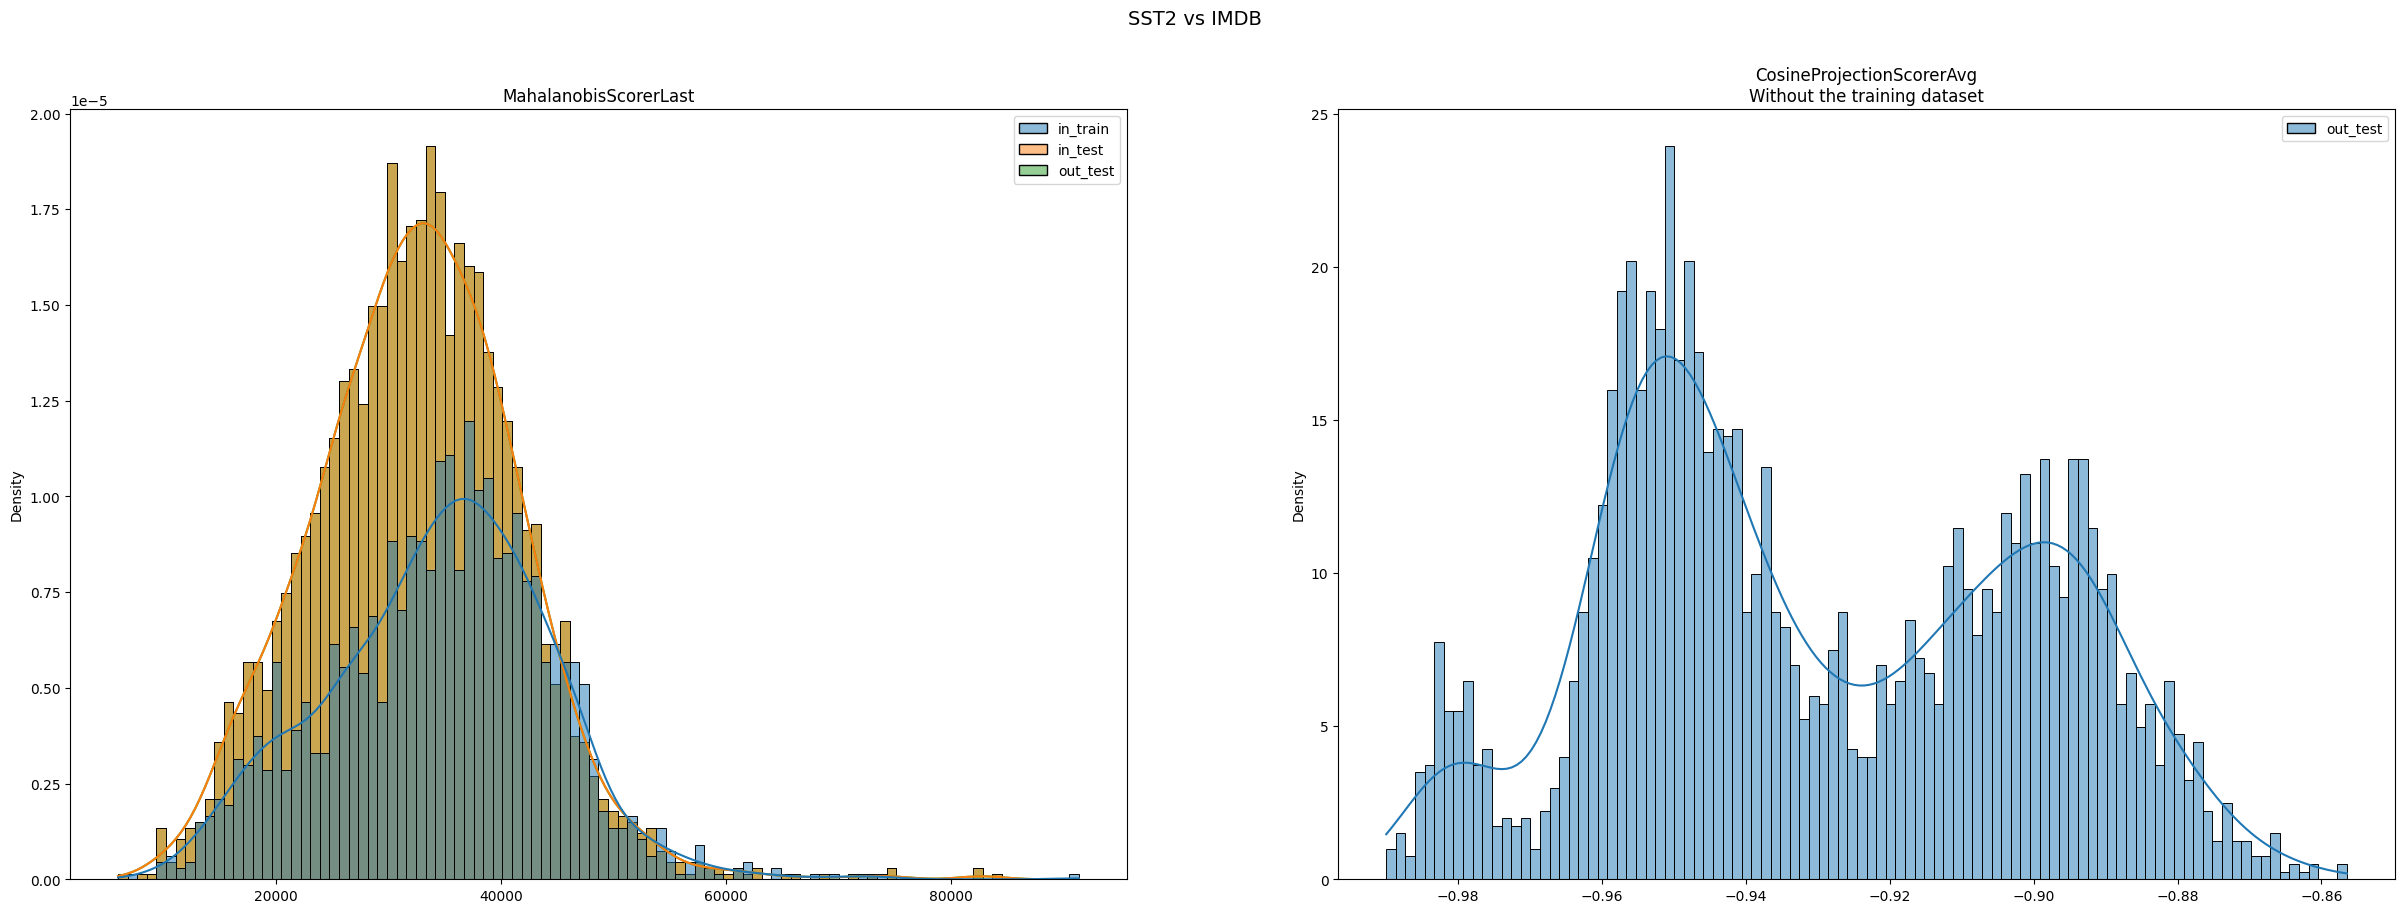

In [71]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(30, 10))
fig.suptitle("SST2 vs IMDB", size=14)    

for (scorer, records), ax in zip(all_scores.items(), axes.flatten()):
    plot_scorer_distrib(scorer, records, datasets_names=["in_test","out_test"], ax=ax, density=True); 

In [83]:
all_scores

{'MahalanobisScorerLast': {'in_train': [175702.8125,
   123701.9296875,
   166845.21875,
   222232.109375,
   141125.109375,
   65078.57421875,
   159588.125,
   80092.34375,
   172021.921875,
   145724.5,
   123991.2265625,
   126401.5546875,
   151132.96875,
   176417.296875,
   133365.46875,
   152732.453125,
   122491.2734375,
   121536.8515625,
   112162.8671875,
   163631.375,
   112188.140625,
   150783.53125,
   165176.34375,
   140490.859375,
   181208.453125,
   167579.5625,
   193352.09375,
   187818.640625,
   105191.3984375,
   184373.40625,
   200025.34375,
   167254.59375,
   122368.3515625,
   161759.375,
   171560.796875,
   69424.1171875,
   121249.640625,
   181709.46875,
   161128.3125,
   190218.9375,
   146031.46875,
   198571.90625,
   84167.65625,
   71741.359375,
   151795.84375,
   139134.96875,
   236210.625,
   225309.109375,
   233978.59375,
   128627.5703125,
   219550.21875,
   137939.625,
   124624.0,
   219547.03125,
   116006.21875,
   228021.203125,
 

### **Metrics** 

In [101]:
#len(all_scores['MahalanobisScorerLast']["in_train"])
len(all_scores['MahalanobisScorerLast']["in_test"])


1000

In [92]:
ood_scores = {
    scorer: list(chain(*[
        ele for ele in all_scores[scorer].values()
    ]))
    for scorer in scorer_names
}

In [99]:
len(ood_scores["MahalanobisScorerLast"])

3000

In [108]:
ood_labels_in = [0 for i in range(2000)]
ood_labels_out = [1 for i in range(1000)]
ood_labels = ood_labels_in + ood_labels_out 


roc = {
    scorer: roc_curve(ood_labels, ood_scores[scorer], pos_label=1)
    for scorer in scorer_names
}

In [109]:
roc

{'MahalanobisScorerLast': (array([0.000e+00, 5.000e-04, 1.000e-03, 1.500e-03, 4.000e-03, 5.000e-03,
         6.000e-03, 7.000e-03, 8.000e-03, 9.000e-03, 9.500e-03, 1.000e-02,
         1.250e-02, 1.350e-02, 1.400e-02, 1.450e-02, 1.500e-02, 1.550e-02,
         1.750e-02, 1.850e-02, 2.000e-02, 2.100e-02, 2.150e-02, 2.250e-02,
         2.300e-02, 2.350e-02, 2.400e-02, 2.450e-02, 2.500e-02, 2.600e-02,
         2.850e-02, 3.000e-02, 3.100e-02, 3.400e-02, 3.500e-02, 3.550e-02,
         3.650e-02, 3.700e-02, 3.800e-02, 3.850e-02, 3.950e-02, 4.100e-02,
         4.500e-02, 4.550e-02, 4.700e-02, 4.750e-02, 5.000e-02, 5.250e-02,
         5.350e-02, 5.550e-02, 5.600e-02, 5.700e-02, 5.800e-02, 5.850e-02,
         6.000e-02, 6.050e-02, 6.250e-02, 6.300e-02, 6.350e-02, 6.400e-02,
         6.450e-02, 6.650e-02, 6.800e-02, 6.850e-02, 6.900e-02, 6.950e-02,
         7.250e-02, 7.350e-02, 7.450e-02, 7.600e-02, 7.650e-02, 7.750e-02,
         7.900e-02, 7.950e-02, 8.000e-02, 8.100e-02, 8.200e-02, 8.300e-02,


In [90]:
ood_scores

{'MahalanobisScorerLast': [175702.8125,
  123701.9296875,
  166845.21875,
  222232.109375,
  141125.109375,
  65078.57421875,
  159588.125,
  80092.34375,
  172021.921875,
  145724.5,
  123991.2265625,
  126401.5546875,
  151132.96875,
  176417.296875,
  133365.46875,
  152732.453125,
  122491.2734375,
  121536.8515625,
  112162.8671875,
  163631.375,
  112188.140625,
  150783.53125,
  165176.34375,
  140490.859375,
  181208.453125,
  167579.5625,
  193352.09375,
  187818.640625,
  105191.3984375,
  184373.40625,
  200025.34375,
  167254.59375,
  122368.3515625,
  161759.375,
  171560.796875,
  69424.1171875,
  121249.640625,
  181709.46875,
  161128.3125,
  190218.9375,
  146031.46875,
  198571.90625,
  84167.65625,
  71741.359375,
  151795.84375,
  139134.96875,
  236210.625,
  225309.109375,
  233978.59375,
  128627.5703125,
  219550.21875,
  137939.625,
  124624.0,
  219547.03125,
  116006.21875,
  228021.203125,
  209976.046875,
  208603.21875,
  149121.1875,
  259182.734375,
  17

In [74]:
ood_labels_in = [
    config_args_sst2["ood_label"] 
    for _ in range(config_args_sst2["train_size"]+1821) 
]

ood_labels_out = [
    config_args_imdb["ood_label"] 
    for _ in range(config_args_imdb["test_size"])
]


ood_labels = ood_labels_in + ood_labels_out  


ood_scores = {
    scorer: list(chain(*[
        ds for ds in all_scores[scorer].values()
    ]))
    for scorer in scorer_names
}

roc = {
    scorer: roc_curve(ood_labels, ood_scores[scorer], pos_label=1)
    for scorer in scorer_names
}

prc = {
    scorer: precision_recall_curve(ood_labels, ood_scores[scorer], pos_label=1)
    for scorer in scorer_names
}

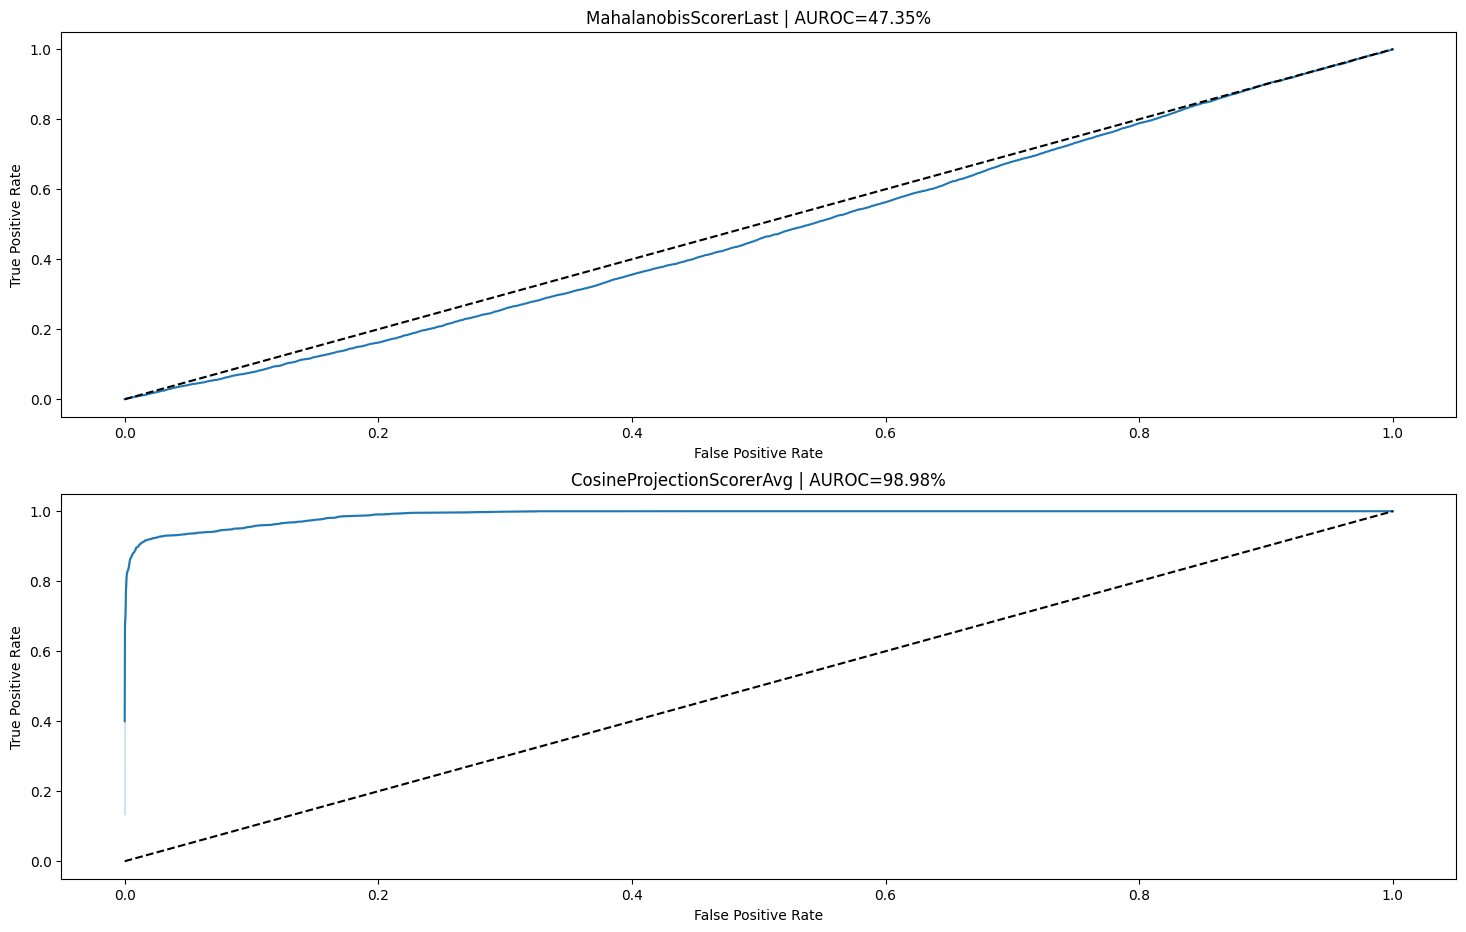

In [76]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 11))

for (scorer, (fpr, tpr, _)), ax in zip(roc.items(), axes.flatten()): 
    sns.lineplot(x=fpr, y=tpr, ax=ax)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", ax=ax, color="black") 

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")

    auroc = auc(fpr, tpr)
    ax.set_title(f"{scorer} | AUROC={round(100*auroc, 2)}%"); 

In [ ]:
file_name = "./backup/records_in_test.pkl"

with open(file_name, "wb") as file: 
    pkl.dump(records_in_test, file)

del records_in_test

#### OUT

In [ ]:
print("Evaluating on the out-of-distribution ATIS dataset")

records_out_atis = evaluate_dataloader(
    model,
    test_loader_imdb,
    tokenizer,
    detectors
)

Evaluating on the out-of-distribution ATIS dataset


Evaluating detectors...:   0%|          | 0/188 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating detectors...: 100%|██████████| 188/188 [56:33<00:00, 18.05s/it]   


In [ ]:
file_name = "./backup/records_out_atis.pkl"

with open(file_name, "wb") as file: 
    pkl.dump(records_out_atis, file)

del records_out_atis

In [ ]:
print("Evaluating on the out-of-distribution BITEXT dataset")

records_out_bitext = evaluate_dataloader(
    model,
    test_loader_bitext,
    tokenizer,
    detectors
)

Evaluating on the out-of-distribution BITEXT dataset

Evaluating detectors...: 100%|██████████| 188/188 [09:59<00:00,  3.19s/it]


In [ ]:
file_name = "./backup/records_out_bitext.pkl"

with open(file_name, "wb") as file: 
    pkl.dump(records_out_bitext, file)

del records_out_bitext

## Results

### Load records

In [ ]:
# records = {
#     record_type: load_records(record_type)
#     for record_type in (
#         "in_train", 
#         "in_test", 
#         #"out_atis", 
#         #"out_bitext"
#     )
# }


records = {"in_train": records_in_test, "in_test": records_in_train}

In [ ]:
records

{'in_train': {'MahalanobisScorer(layers={-1},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_-1_class_0': [33388.015625,
   32938.9765625,
   35703.69140625,
   45288.203125,
   31143.146484375,
   14085.5107421875,
   36219.625,
   20256.47265625,
   37267.37109375,
   31244.73046875,
   27647.533203125,
   30101.494140625,
   30266.037109375,
   36781.3515625,
   28097.587890625,
   36973.48828125,
   27806.875,
   24995.37109375,
   25843.04296875,
   32293.509765625,
   25513.953125,
   30834.798828125,
   35985.05078125,
   28451.478515625,
   40668.41796875,
   37062.71484375,
   41492.38671875,
   47009.51953125,
   22955.427734375,
   38262.19921875,
   39368.66796875,
   38562.28125,
   25534.748046875,
   31955.61328125,
   37655.61328125,
   16931.408203125,
   29311.419921875,
   35480.0859375,
   37171.9375,
   37873.59765625,
   30178.857421875,
   42095.0703125,
   20425.921875,
   15228.041015625,
   33769.5703125,
   28484.265625,
   45581.08203125,

In [ ]:
maha_key = list(records["in_train"].keys())[0]

for record_type, records_ in records.items(): 
    # average CosineProjectionScorer over all hidden layers
    print(record_type, records_)
    records[record_type]["CosineProjectionScorerAvg"] = average_scorer_per_layer(records_, "CosineProjectionScorer")

    # simplify MahalanobisScorer key name 
    records[record_type]["MahalanobisScorerLast"] = records[record_type][maha_key]

In [ ]:
records["in_train"].keys()

dict_keys(['MahalanobisScorer(layers={-1},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_-1_class_0', 'CosineProjectionScorer(layers={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+0_0', 'CosineProjectionScorer(layers={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+1_0', 'CosineProjectionScorer(layers={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+2_0', 'CosineProjectionScorer(layers={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+3_0', 'CosineProjectionScorer(layers={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+4_0', 'CosineProjectionScorer(layers={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+5_0', 'CosineProjectionScorer(l

### Scorer distribution

#### All datasets

In [ ]:
scorer_names = [
    "MahalanobisScorerLast", 
    "CosineProjectionScorerAvg", 
    #"msp", 
    #"energy"
]

all_scores = {
    scorer: {
        record_type: records[record_type][scorer]
        for record_type in records.keys()
    }
    for scorer in scorer_names
}


# all_scores = { 
#     scorer : {"in_train" : }
# }

In [ ]:
all_scores['C']

dict_keys(['MahalanobisScorerLast', 'CosineProjectionScorerAvg'])

In [ ]:
DS

['in_train', 'in_test']

In [ ]:
all_scores

{'MahalanobisScorerLast': {'in_train': [33388.015625,
   32938.9765625,
   35703.69140625,
   45288.203125,
   31143.146484375,
   14085.5107421875,
   36219.625,
   20256.47265625,
   37267.37109375,
   31244.73046875,
   27647.533203125,
   30101.494140625,
   30266.037109375,
   36781.3515625,
   28097.587890625,
   36973.48828125,
   27806.875,
   24995.37109375,
   25843.04296875,
   32293.509765625,
   25513.953125,
   30834.798828125,
   35985.05078125,
   28451.478515625,
   40668.41796875,
   37062.71484375,
   41492.38671875,
   47009.51953125,
   22955.427734375,
   38262.19921875,
   39368.66796875,
   38562.28125,
   25534.748046875,
   31955.61328125,
   37655.61328125,
   16931.408203125,
   29311.419921875,
   35480.0859375,
   37171.9375,
   37873.59765625,
   30178.857421875,
   42095.0703125,
   20425.921875,
   15228.041015625,
   33769.5703125,
   28484.265625,
   45581.08203125,
   44595.953125,
   48369.609375,
   30373.99609375,
   43454.390625,
   29190.0136718

TypeError: plot_scorer_distrib() got an unexpected keyword argument 'ds_names'

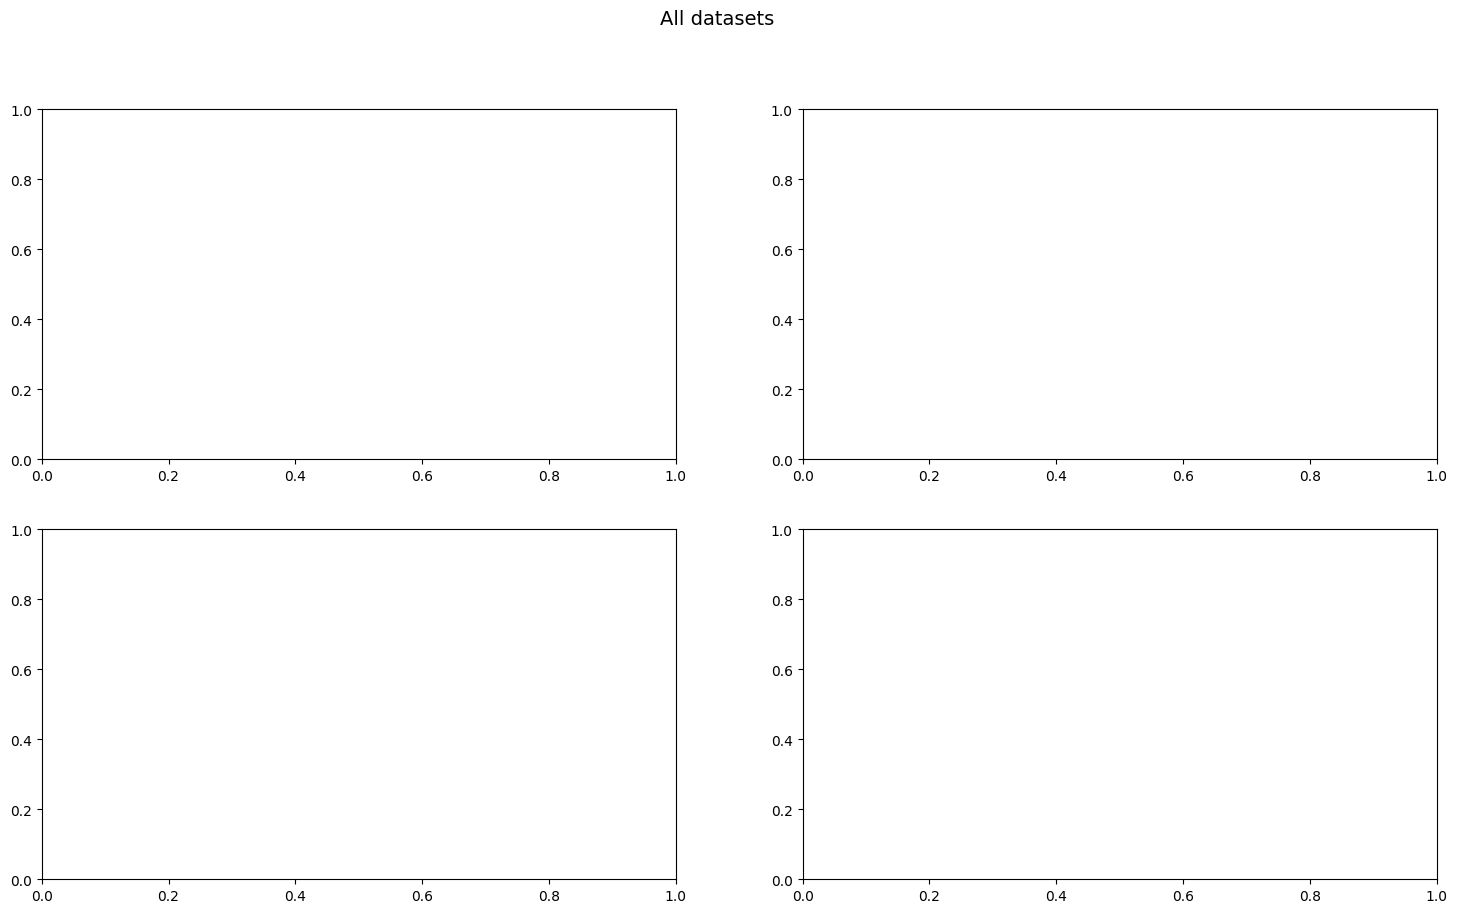

In [55]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 10))
fig.suptitle("All datasets", size=14)    

for (scorer, records), ax in zip(all_scores.items(), axes.flatten()):
    plot_scorer_distrib(
        scorer, 
        records,
        ds_names=["in_test","out_test"], 
        ax=ax, 
        density=True); 

#### `banking77`

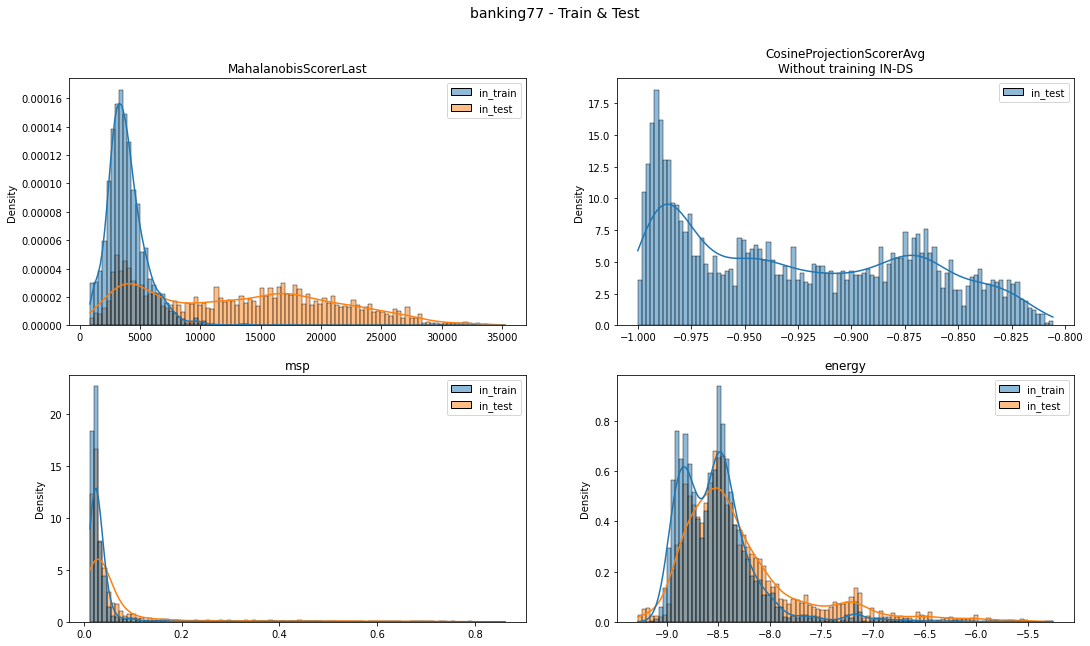

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 10))
fig.suptitle("banking77 - Train & Test", size=14)

for (scorer, records), ax in zip(all_scores.items(), axes.flatten()):
    plot_scorer_distrib(
        scorer, 
        records,
        ds_names=["in_train", "in_test"], 
        ax=ax, 
        density=True); 

#### `banking77` & `ATIS`

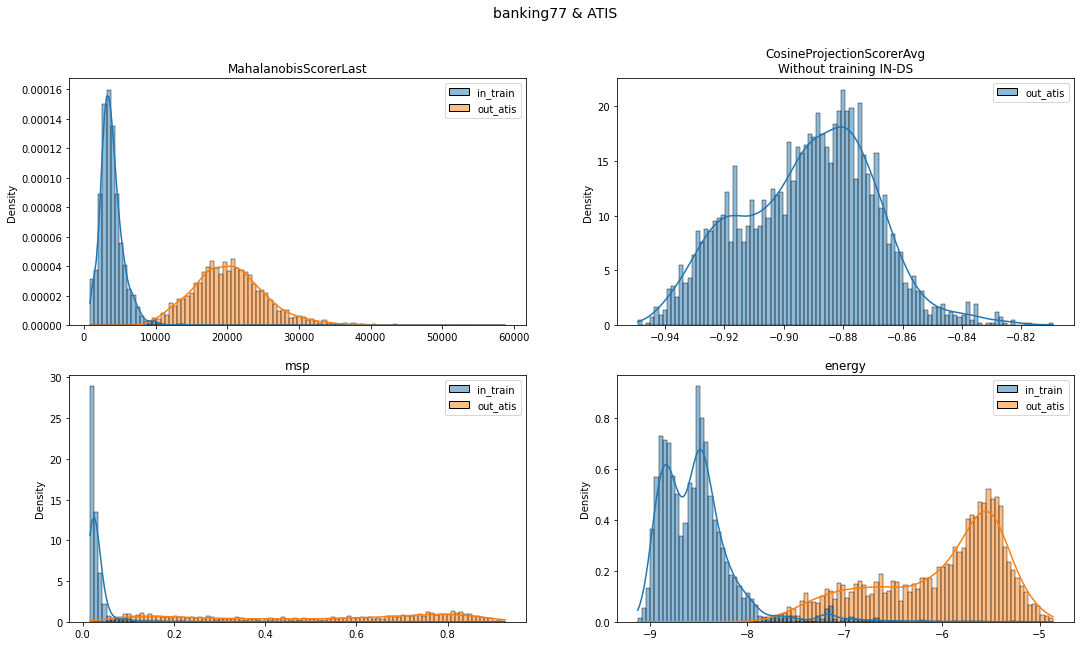

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 10))
fig.suptitle("banking77 & ATIS", size=14)

for (scorer, records), ax in zip(all_scores.items(), axes.flatten()):
    plot_scorer_distrib(
        scorer, 
        records,
        ds_names=["in_train", "out_atis"], 
        ax=ax, 
        density=True); 

#### `banking77` & `Bitext`

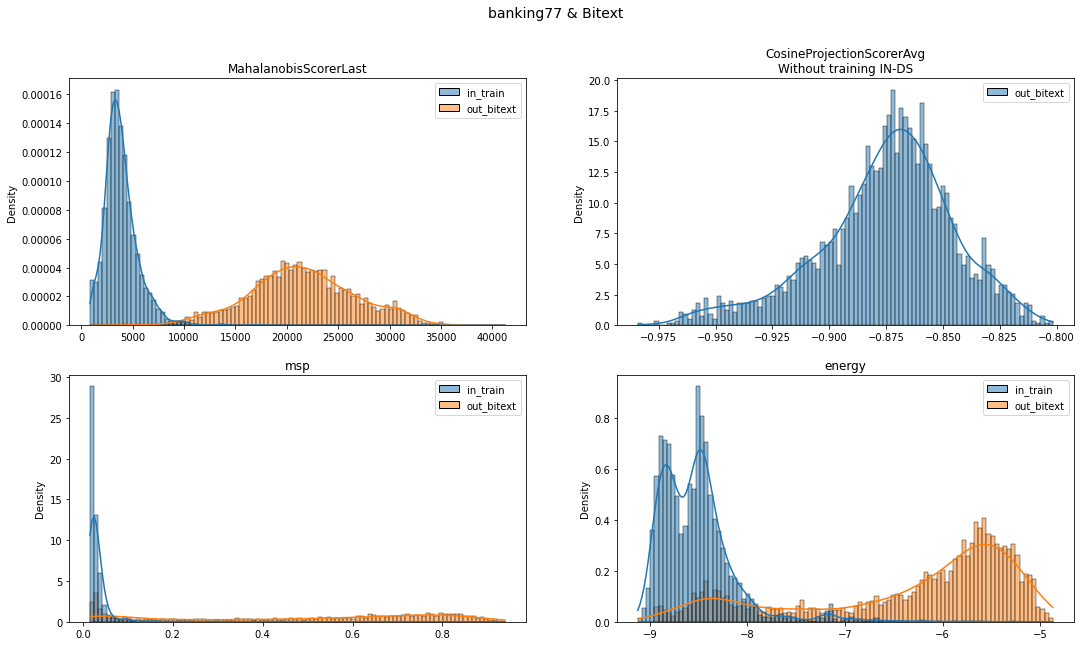

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 10))
fig.suptitle("banking77 & Bitext", size=14)

for (scorer, records), ax in zip(all_scores.items(), axes.flatten()):
    plot_scorer_distrib(
        scorer, 
        records,
        ds_names=["in_train", "out_bitext"], 
        ax=ax, 
        density=True); 

### Metrics

In [ ]:
# get OOD labels 
    # 0 for IN-DS samples
    # 1 for OUT-DS samples

ood_labels_in = [
    config_args_in["ood_label"] 
    for _ in range(config_args_in["train_size"]+config_args_in["test_size"])
]

ood_labels_out = [
    config_args_out["ood_label"] 
    for _ in range(config_args_out["test_size"])
]

# IN-DS (b77) labels + OUT-DS labels (atis) + OUT-DS labels (bitext)
ood_labels = ood_labels_in + ood_labels_out + ood_labels_out

# get OOD scores for each scoring function
ood_scores = {
    scorer: list(chain(*[
        ds for ds in all_scores[scorer].values()
    ]))
    for scorer in scorer_names
}

# compute (fpr, tpr) for different thresolds
roc = {
    scorer: roc_curve(ood_labels, ood_scores[scorer], pos_label=1)
    for scorer in scorer_names
}

# compute (precision, recall) for different thresolds
prc = {
    scorer: precision_recall_curve(ood_labels, ood_scores[scorer], pos_label=1)
    for scorer in scorer_names
}

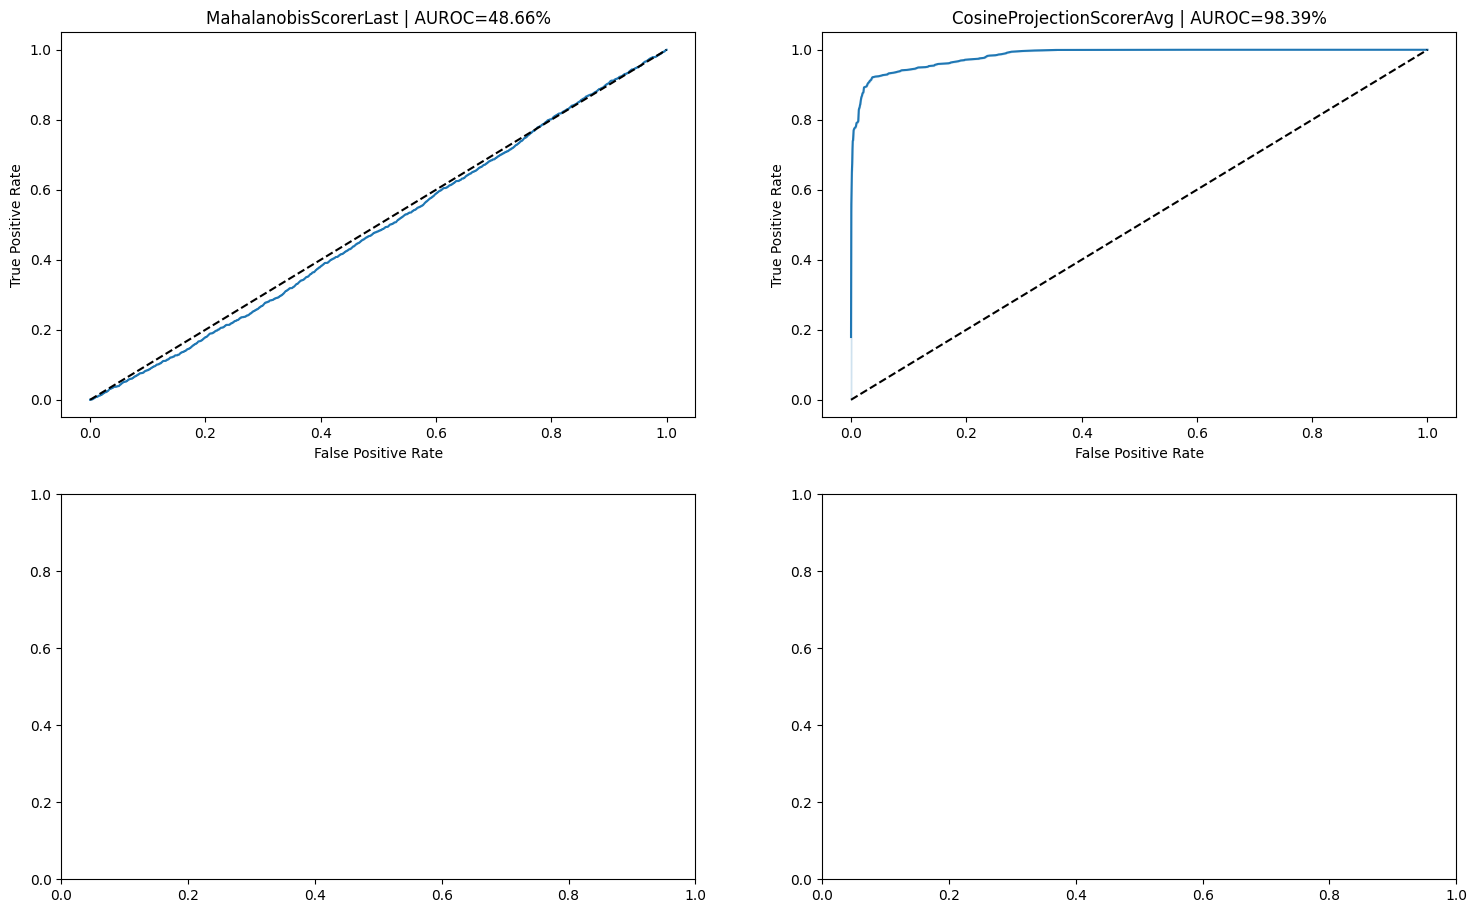

In [110]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 11))

for (scorer, (fpr, tpr, _)), ax in zip(roc.items(), axes.flatten()): 
    sns.lineplot(x=fpr, y=tpr, ax=ax)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", ax=ax, color="black") 

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")

    auroc = auc(fpr, tpr)
    ax.set_title(f"{scorer} | AUROC={round(100*auroc, 2)}%"); 

**Note**: precision & recall

$$
\begin{aligned}
\text{Pr}  & = \mathbb{P}(Z=1 \mid s(\mathrm{x}) \leq \gamma) \\
\text{Re} & = \mathbb{P}(s(\mathrm{x}) \leq \gamma \mid Z=1)
\end{aligned}
$$

where $s(.)$ is the scoring function and $\gamma$ the thresold. 

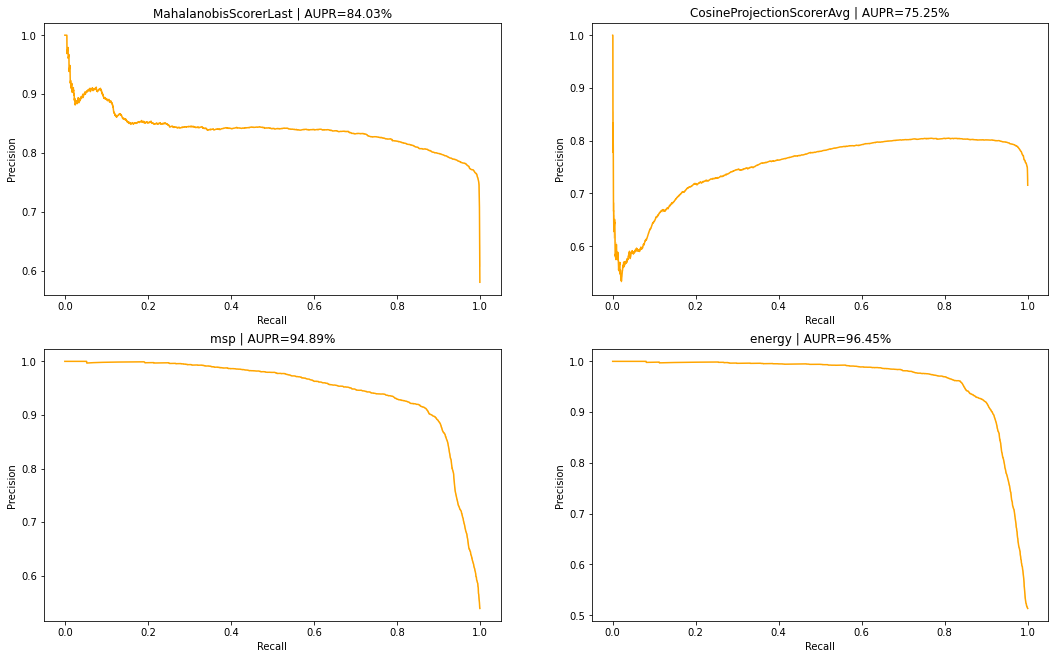

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 11))

for (scorer, (precision, recall, _)), ax in zip(prc.items(), axes.flatten()): 
    sns.lineplot(x=recall, y=precision, ax=ax, color="orange")

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

    aupr = auc(recall, precision)
    ax.set_title(f"{scorer} | AUPR={round(100*aupr, 2)}%"); 

In [ ]:
SCORERS =  ["CosineProjectionScorer", "MahalanobisScorer", "DataDepthScorer"]
DS = ["in_train", "in_test"] #"out_atis", "out_bitext"]

def load_records(record_type: str) -> Dict:


    file_name = f"./backup/records_{record_type}.pkl"
    with open(file_name, "rb") as file: 
        records = pkl.load(file)

    return records

def average_scorer_per_layer(records: Dict, scorer_name: str) -> np.ndarray:
    """Description. Average scorer values across multiple layers."""

    if scorer_name not in SCORERS:
        raise ValueError(f"scorer_name must be in {SCORERS}")

    values_per_layer = [
        values 
        for key, values in records.items()
        if scorer_name in key
    ]

    return np.mean(values_per_layer, axis=0)

def get_scorer_per_layer(records: Dict, scorer_name: str, layer: int) -> List: 
    """Description. Return scorer values for one layer."""

    if scorer_name not in SCORERS:
        raise ValueError(f"scorer_name must be in {SCORERS}")

    values = [
        values 
        for key, values in records.items()
        if scorer_name in key and str(layer) in key
    ]

    return values[0]

def plot_scorer_distrib(
    scorer: str, 
    records: List, 
    ds_names: List, 
    ax: Axes, 
    density: bool
  ): 
    """Description. Return histogram/density plot for scorer values.
    
    Details: if scorer is CosineProjectionScorer, only test in-ds and out-ds are plotted."""

    for ds in ds_names: 
        if ds not in DS: 
          raise ValueError(f"{ds} not in {DS}.")

    tmp =pd.concat([pd.DataFrame(records['in_train']),pd.DataFrame(records['in_test'])], axis=1)
    tmp.columns = ["in_train","in_test"]
    title = scorer

    # if "CosineProjectionScorer" in scorer and "in_train" in tmp.columns:
    #     tmp = tmp.drop(labels=["in_train"], axis=1)
    #     title += "\nWithout training IN-DS"

    if density: 
        args = {"stat": "density", "kde": True}
    else: 
        args = {}

    sns.histplot(data=tmp, ax=ax, bins=100, **args)

    ax.set_title(title) 